In [1]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Dropout,Flatten,MaxPool2D,BatchNormalization,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os

def directory_to_df(path: str):
    df = []
    characters = 'abcdefghijklmnopqrstuvwxyz'

    for cls in os.listdir(path):
        class_path = os.path.join(path,cls)
        if not os.path.isdir(class_path):
            continue
        class_name = cls.split('_')[0]
        if not class_name.isalpha():
            continue
        if not class_name in characters:
            continue
        for image_path in os.listdir(class_path):
            entry = os.path.join(class_path, image_path)
            df.append([entry, class_name])
    df = pd.DataFrame(df, columns=['image','label'])
    print("The number of sample images is: ",len(df))
    return df.copy()

def read_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.color_BGR2RGB)
    return image

def show_image(image, label=None):
    plt.imshow(image,cmap='gray')
    plt.axis('off')
    plt.title(label)
    plt.show
    
def callbacks(model_name):
    early_stopping = EarlyStopping(monitor='val_loss', patience=9, start_from_epoch=9, verbose=0)
    reduce_lr = ReduceLROnPlateau(patience=5, factor=0.5, min_delta=0.01)
    model_checkpoint = ModelCheckpoint(f'{model_name}.keras', verbose=1, save_best_only=True)
    return [early_stopping,reduce_lr,model_checkpoint]

In [3]:

image_shape = (32,32)
image_size = (32,32,3)
batch_size = 32
optimizer = Adam
loss = CategoricalCrossentropy()
epochs = 20

In [4]:
#reading the dataset
path = r'C:\Users\HP\Downloads\archive (1)\dataset'
df = directory_to_df(path)
df.head(5)

The number of sample images is:  85199


,image,label
0,C:\Users\HP\Downloads\archive (1)\dataset\a_L\...,a
1,C:\Users\HP\Downloads\archive (1)\dataset\a_L\...,a
2,C:\Users\HP\Downloads\archive (1)\dataset\a_L\...,a
3,C:\Users\HP\Downloads\archive (1)\dataset\a_L\...,a
4,C:\Users\HP\Downloads\archive (1)\dataset\a_L\...,a


In [5]:
df.label.value_counts()

label
e    3284
r    3284
a    3281
m    3281
n    3281
q    3279
u    3278
i    3277
d    3277
s    3276
y    3276
x    3276
k    3276
l    3276
t    3276
f    3275
w    3275
p    3275
g    3275
o    3275
h    3275
z    3275
c    3274
v    3274
b    3274
j    3274
Name: count, dtype: int64

In [6]:
#split dataset
x, y = df['image'], df['label']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
train_df = pd.concat([x_train,y_train],axis=1)
test_df = pd.concat([x_test,y_test],axis=1)

In [7]:
from sklearn.model_selection import StratifiedKFold
#Extract features and labels
X = train_df['image'].values
y = train_df['label'].values
#Initialize StratifiedKFold
split = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#Perform the split
for train_index, val_index in split.split(X, y):
    #Use iloc to create the train and validation sets
    train_data = train_df.iloc[train_index].reset_index(drop=True)
    val_data = train_df.iloc[val_index].reset_index(drop=True)
    break  # Use only the first split


In [9]:
train_data['label'].nunique(), val_data['label'].nunique()

(26, 26)

In [10]:
train_data.shape

(54527, 2)

In [11]:
#design the image generator
gen1 = ImageDataGenerator(fill_mode='nearest',dtype=np.int32,brightness_range=[0.0,1.0])
gen2 = ImageDataGenerator(fill_mode='nearest',dtype=np.int32)

training_gen = gen1.flow_from_dataframe(train_data, x_col='image',y_col='label',batch_size=batch_size,
                                       target_size=(32,32),shuffle=True)
validation_gen = gen1.flow_from_dataframe(val_data, x_col='image',y_col='label',batch_size=batch_size,
                                       target_size=(32,32),shuffle=False)



Found 54527 validated image filenames belonging to 26 classes.
Found 13632 validated image filenames belonging to 26 classes.


In [12]:
mapping = training_gen.class_indices
inverse_mapping = dict(map(lambda x: tuple(reversed(x)), mapping.items()))
print(inverse_mapping)

{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z'}


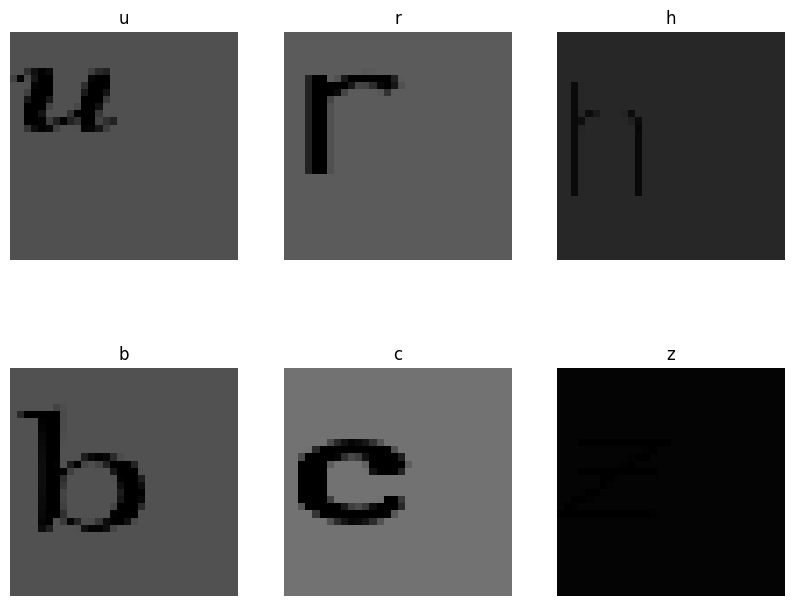

In [13]:
#display sample images
plt.figure(figsize=(10,8))
for batch_num in range(6): 
    img_num = 8
    ax = plt.subplot(2,3,batch_num+1)
    show_image(training_gen[batch_num][0][img_num], inverse_mapping[training_gen[batch_num][1][img_num].argmax()])

In [14]:
#convolutional neural network
from tensorflow.keras import layers
cnn_model = Sequential([
    layers.Input(shape=image_size, batch_size=batch_size,name='input'),
    layers.Conv2D(3, (3,3), strides=1, activation='relu',padding='same'),
    layers.Conv2D(128, (3,3), strides=1, activation='relu',padding='same'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(256, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(256, (3,3), activation='relu',padding='same'),
    layers.Dropout(0.2),
    layers.Conv2D(512, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(1024, (3,3), strides=2, activation='relu',padding='same'),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(1024, activation='selu'),
    layers.Dense(len(mapping), activation='softmax')
    
    
])

In [15]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (32, 32, 32, 3)             │              84 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 32, 32, 128)           │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 16, 16, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 14, 14, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 7, 7, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 7, 7, 256)             │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (32, 7, 7, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 5, 5, 512)             │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 2, 2, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 1, 1, 1024)            │       4,719,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (32, 1, 1, 1024)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 1024)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 1024)                  │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 26)                    │          26,650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,864,942 (30.00 MB)

 Trainable params: 7,864,942 (30.00 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
cnn_model.compile(optimizer='adam',loss=loss,metrics=['accuracy'])

In [17]:
history = cnn_model.fit(training_gen, epochs=20, validation_data=validation_gen, callbacks=callbacks('cnn_model'))

Epoch 1/20
1704/1704 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5537 - loss: 1.9250
Epoch 1: val_loss improved from inf to 0.36053, saving model to cnn_model.keras
1704/1704 ━━━━━━━━━━━━━━━━━━━━ 4763s 3s/step - accuracy: 0.5538 - loss: 1.9244 - val_accuracy: 0.9017 - val_loss: 0.3605 - learning_rate: 0.0010
Epoch 2/20
1704/1704 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8987 - loss: 0.3652
Epoch 2: val_loss improved from 0.36053 to 0.26018, saving model to cnn_model.keras
1704/1704 ━━━━━━━━━━━━━━━━━━━━ 5493s 3s/step - accuracy: 0.8987 - loss: 0.3652 - val_accuracy: 0.9252 - val_loss: 0.2602 - learning_rate: 0.0010
Epoch 3/20
1704/1704 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9164 - loss: 0.3090
Epoch 3: val_loss improved from 0.26018 to 0.24815, saving model to cnn_model.keras
1704/1704 ━━━━━━━━━━━━━━━━━━━━ 4727s 3s/step - accuracy: 0.9164 - loss: 0.3090 - val_accuracy: 0.9330 - val_loss: 0.2482 - learning_rate: 0.0010
Epoch 4/20
1704/1704 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - a

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="image",  # Column name with file paths
    y_col="label",     # Column name with labels
    target_size=(32, 32),
    batch_size=32,
    class_mode="categorical"  # or "binary" depending on your problem
)

scores = cnn_model.evaluate(test_generator)
print(f"Test loss: {scores[0]}, Test accuracy: {scores[1]}")


Found 17040 validated image filenames belonging to 26 classes.
533/533 ━━━━━━━━━━━━━━━━━━━━ 513s 940ms/step - accuracy: 0.9243 - loss: 0.2585
Test loss: 0.25007256865501404, Test accuracy: 0.9280516505241394


In [23]:
history.params

{'verbose': 'auto', 'epochs': 20, 'steps': 1704}

In [24]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])

In [28]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

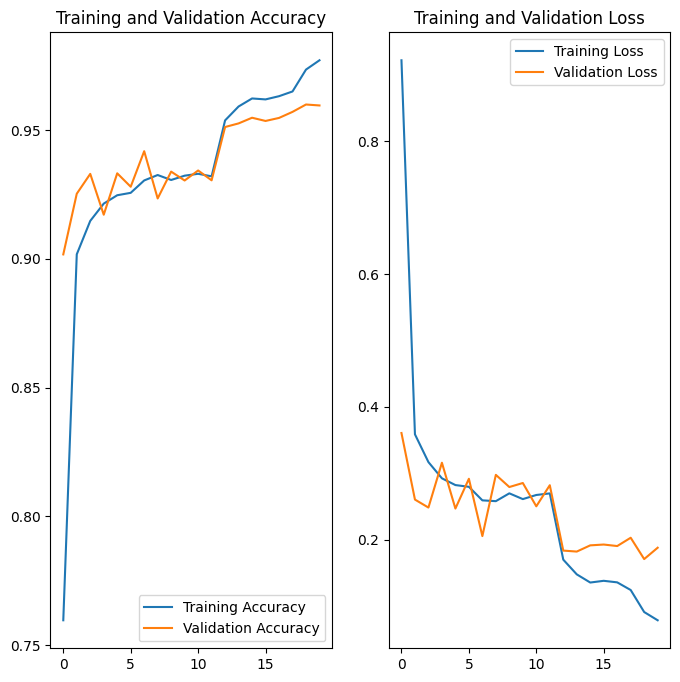

In [29]:
#plot a graph of these metrics

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(epochs), accuracy, label='Training Accuracy')
plt.plot(range(epochs), val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title("Training and Validation Loss")



First predicted image
Actual label: v
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Predicted label: v
Confidence: 1.0


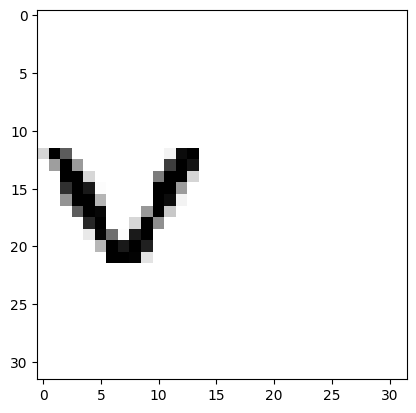

In [41]:
#run prediction on sample image
import numpy as np
#test_df = tf.data.Dataset.from_tensor_slices(('image', 'label'))
image_batch, label_batch = next(test_generator)
image = image_batch[0]
if image.dtype != np.uint8:
    image = (image * 255).astype('uint8')  # Scale back to 0-255 range

# Check for grayscale and convert to RGB if necessary
if len(image.shape) == 2 or image.shape[-1] == 1:
    image = np.stack((image,) * 3, axis=-1)
label_batch = np.argmax(label_batch[0])
print("First predicted image")
print("Actual label:",inverse_mapping[label_batch])
plt.imshow(image)
#add a batch dimension by using np.expand_dims()
image_batch_with_dim = np.expand_dims(image, 0)
prediction_batch = cnn_model.predict(image_batch_with_dim)
predicted_label = np.argmax(prediction_batch[0])
print("Predicted label:", inverse_mapping[predicted_label])
print("Confidence:", round(np.max(prediction_batch[0]), 2))

In [42]:
#function for inference
def predict(model, image):
    image_array = tf.keras.preprocessing.image.img_to_array(image)
    image_array = tf.expand_dims(image_array, 0)
    prediction_label = inverse_mapping[np.argmax(cnn_model.predict(image_array))]
    confidence = round(100 * np.max(cnn_model.predict(image_array)),2)
    return prediction_label, confidence    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


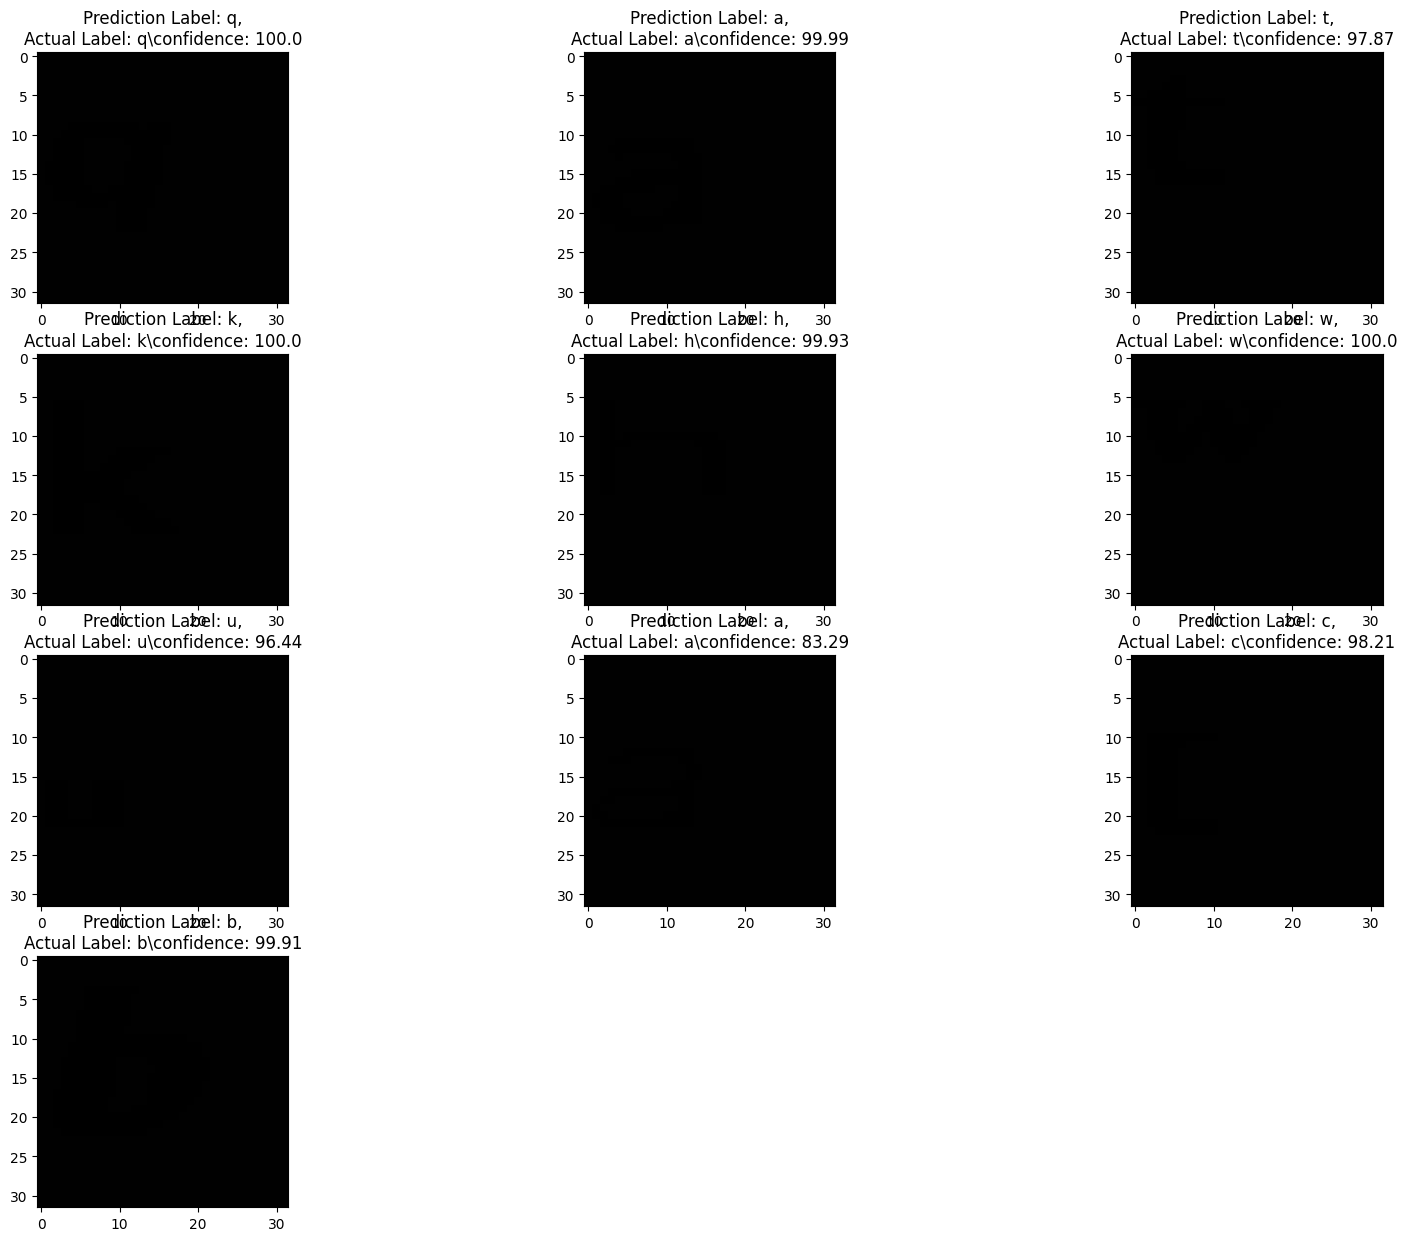

In [45]:
plt.figure(figsize=(20,15))
image_batch, label_batch = next(test_generator)
for i in range(10):
    image = image_batch[i]
    if image.dtype != np.uint8:
        image = (image * 255).astype('uint8')  # Scale back to 0-255 range

    # Check for grayscale and convert to RGB if necessary
    if len(image.shape) == 2 or image.shape[-1] == 1:
        image = np.stack((image,) * 3, axis=-1)
    plt.subplot(3,3,i+1)
    plt.imshow(image.astype('uint8'))
    prediction_label, confidence = predict(cnn_model, image)
    plt.title(f"Prediction Label: {prediction_label},\nActual Label: {inverse_mapping[np.argmax(label_batch[i])]}\confidence: {confidence}")